In [ ]:
%pip install opencv-python matplotlib imageio gdown

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
import gdown
import pdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

In the above cell block, the memory growth allows TensorFlow to allocate only as much GPU memory as needed by the process, rather than allocating the entire GPU memory upfront. This can be beneficial for improving memory utilization.

# 1. Build Data Loading Functions

In [ ]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

In [4]:
import cv2
import tensorflow as tf
from typing import List

def load_video(path: str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    
    # Iterate over each frame in the video
    while True:
        ret, frame = cap.read()
        
        # If there are no more frames, break the loop
        if not ret:
            break
        
        # Convert frame to grayscale
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Crop frame to desired dimensions
        frame = frame[190:236, 80:220]
        
        # Resize frame to match expected shape
        frame = cv2.resize(frame, (140, 46))
        
        # Add a channel dimension to the frame
        frame = tf.expand_dims(frame, axis=-1)
        
        # Convert frame to float32
        frame = tf.cast(frame, tf.float32)
        
        # Append the processed frame to the list of frames
        frames.append(frame)
    
    cap.release()

    # Stack the list of frames into a single tensor
    frames = tf.stack(frames)
    
    # Compute mean and standard deviation of the frames
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(frames)
    
    # Normalize the frames
    frames = tf.cast((frames - mean), tf.float32) / std
    
    return frames


In [5]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [6]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


This code sets up two StringLookup layers using TensorFlow's Keras API, which is commonly used for mapping characters (or tokens) to numerical indices and vice versa.  Refer to this: "https://keras.io/examples/audio/ctc_asr/"

In [7]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

function reads alignments from a file, extracts tokens excluding silence tokens, splits each token into characters, converts each character to a numerical index, and returns the result as a list of strings.

In [8]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split(os.path.sep)[-1].split('.')[0]  # Assuming you're on Windows
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments


 the file paths are provided as input, and the function returns the corresponding video frames and alignment data. It assumes a specific directory structure where video files are located in the 'data/s1' directory and alignment files are located in the 'data/alignments/s1' directory.

In [9]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result


Overall, this function wraps the load_data function using tf.py_function() to make it compatible with TensorFlow's graph execution. It's suitable for use with TensorFlow datasets when you need to process data files in a pipeline, such as loading video frames and alignments from paths specified in the dataset

# 2. Create Data Pipeline

we need to build a data pipeline that will be used to train the Deep learning model Tensorflow will draw random samples from our data set to complete one training step. we also needed to look at the data to make sure our Transformations have worked successfully.

In [10]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
train = data.take(450)
test = data.skip(450)

frames, alignments = data.as_numpy_iterator().next()

this code sets up a TensorFlow dataset pipeline for efficiently processing video data, including loading, shuffling, mapping preprocessing functions, batching, and prefetching.

In [ ]:
data

In [11]:
frames, alignments = data.as_numpy_iterator().next()

In [13]:
for i in range(200):
  frames, alignments = data.as_numpy_iterator().next()

In [12]:
sample = data.as_numpy_iterator()

In [ ]:
val = sample.next(); val[0]

In [15]:
import numpy as np
import imageio


print("Data Range:", np.min(val[0][0]), "-", np.max(val[0][0]))


max_val = np.max(val[0][0])
min_val = np.min(val[0][0])
frames_normalized = (val[0][0] - min_val) / (max_val - min_val) * 255

frames_uint8 = frames_normalized.astype(np.uint8)

frames_rgb = np.repeat(frames_uint8, 3, axis=-1)

imageio.mimsave('./animation.gif', frames_rgb, fps=10)


Data Range: -4.512167 - 2.4825168


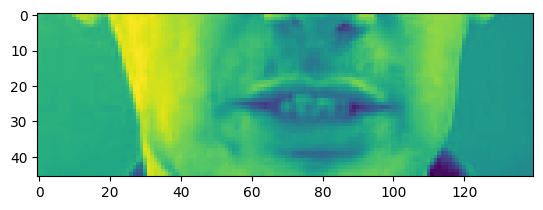

In [16]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][35])

In [17]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue at x nine soon'>

# 3. Design the Deep Neural Network

In [18]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

data.as_numpy_iterator().next()[0][0].shape gives you the shape of the first element in the first batch of your dataset.

In [19]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

here we are defining a Convolutional Neural Network (CNN) followed by a Bidirectional Long Short-Term Memory (BiLSTM) network for some kind of sequential data processing task.
this architecture is designed to process spatiotemporal data such as videos and predict sequences of characters, making it suitable for tasks like video captioning or sign language recognition.

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [21]:
yhat = model.predict(val[0])

1/1 [==============================] - 9s 9s/step


In [22]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b't8888888888888888888888888888888888888888888888888888888888888888888888    '>

In [23]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b't8888888888888888888888888888888888888888888888888888888888888888888888    '>

In [24]:
model.input_shape

(None, 75, 46, 140, 1)

In [25]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [26]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


This function scheduler(epoch, lr) defines a learning rate scheduler that decreases the learning rate exponentially after a certain number of epochs. Here's how it works:

The function takes two arguments: epoch (the current epoch number) and lr (the current learning rate).

If the current epoch number (epoch) is less than 30, the function returns the current learning rate (lr) without any change.
After 30 epochs (epoch >= 30), the function returns the current learning rate multiplied by tf.math.exp(-0.1), which exponentially decreases the learning rate.

In [27]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [28]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [29]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [30]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [31]:
schedule_callback = LearningRateScheduler(scheduler)

In [32]:
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

# 5. Make a Prediction

In [34]:
model.load_weights('models/checkpoint')

In [35]:
test_data = test.as_numpy_iterator()

In [36]:
sample = test_data.next()

In [46]:
yhat = model.predict(sample[0])

1/1 [==============================] - 1s 527ms/step


In [49]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set blue at g eight now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set red in h three again'>]

In [50]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [51]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'set blue at eight now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set red it thre again'>]